# Εργαστηριακή Άσκηση 2. Μη επιβλεπόμενη μάθηση. 
## Σημασιολογική απεικόνιση δεδομένων με χρήση SOM 

 # Στοχεία Ομάδας:
### Γεωργής Ανδρέας      ΑΜ:03115194
### Kουδιγκέλη Χριστιάνα ΑΜ:03113649
### Ομάδα Α43

## Δημιουργία dataset
Στη δεύτερη εφαρμογή θα βασιστούμε στις τοπολογικές ιδιότητες των Self Organizing Maps (SOM) για να φτιάξουμε ενά χάρτη (grid) δύο διαστάσεων όπου θα απεικονίζονται όλες οι ταινίες της συλλογής της ομάδας με τρόπο χωρικά συνεκτικό ως προς το περιεχόμενο και κυρίως το είδος τους. 
Η `build_final_set` αρχικά μετατρέπει την αραιή αναπαράσταση tf-idf της εξόδου της `TfidfVectorizer()` σε πυκνή (η [αραιή αναπαράσταση](https://en.wikipedia.org/wiki/Sparse_matrix) έχει τιμές μόνο για τα μη μηδενικά στοιχεία). 
Στη συνέχεια ενώνει την πυκνή `dense_tf_idf` αναπαράσταση και τις binarized κατηγορίες `catbins` των ταινιών ως επιπλέον στήλες (χαρακτηριστικά). Συνεπώς, κάθε ταινία αναπαρίσταται στο Vector Space Model από τα χαρακτηριστικά του TFIDF και τις κατηγορίες της.
Τέλος, δέχεται ένα ορισμα για το πόσες ταινίες να επιστρέψει, με default τιμή όλες τις ταινίες (5000).

In [1]:
!pip install --upgrade pip
!pip install --upgrade numpy
!pip install --upgrade pandas
!pip install --upgrade nltk
!pip install --upgrade scikit-learn
!pip install unidecode

!pip install requests
from io import StringIO
import requests
import json
import pandas as pd
import numpy as np
from unidecode import unidecode
import nltk
nltk.download('punkt')
from nltk.corpus import stopwords
import string
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import random
from sklearn.externals import joblib

import matplotlib

# we will plot inside the notebook and not in separate window

from sklearn.cluster import KMeans

Requirement already up-to-date: pip in /home/nbuser/anaconda3_501/lib/python3.6/site-packages (18.1)
Requirement already up-to-date: numpy in /home/nbuser/anaconda3_501/lib/python3.6/site-packages (1.16.0)
Requirement already up-to-date: pandas in /home/nbuser/anaconda3_501/lib/python3.6/site-packages (0.23.4)
Requirement already up-to-date: nltk in /home/nbuser/anaconda3_501/lib/python3.6/site-packages (3.4)
Requirement already up-to-date: scikit-learn in /home/nbuser/anaconda3_501/lib/python3.6/site-packages (0.20.2)


[nltk_data] Downloading package punkt to /home/nbuser/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
dataset_url = "https://drive.google.com/uc?export=download&id=1PdkVDENX12tQliCk_HtUnAUbfxXvnWuG"
# make direct link for drive docs this way https://www.labnol.org/internet/direct-links-for-google-drive/28356/
df_data_1 = pd.read_csv(dataset_url, sep='\t',  header=None, quoting=3, error_bad_lines=False)
# βάλτε το seed που αντιστοιχεί στην ομάδα σας
team_seed_number = 42 #ομάδα Α43, επιλέξαμε το 42 καθώς η αρίθμηση πινάκων ξεκινάει από το 0

movie_seeds_url = "https://drive.google.com/uc?export=download&id=1NkzL6rqv4DYxGY-XTKkmPqEoJ8fNbMk_"
df_data_2 = pd.read_csv(movie_seeds_url, header=None, error_bad_lines=False)

my_index = df_data_2.iloc[team_seed_number,:].values
titles = df_data_1.iloc[:, [2]].values[my_index - 1] # movie titles (string)
categories = df_data_1.iloc[:, [3]].values[my_index - 1] # movie categories (string)
bins = df_data_1.iloc[:, [4]]
catbins = bins[4].str.split(',', expand=True).values.astype(np.float)[my_index - 1] # movie categories in binary form (1 feature per category)
summaries =  df_data_1.iloc[:, [5]].values[my_index - 1] # movie summaries (string)
corpus = summaries[:,0].tolist() # list form of summaries

vectorizer = TfidfVectorizer(max_df=0.5, min_df=7, stop_words='english')
vectorizer.fit(corpus)
corpus_tf_idf = vectorizer.transform(corpus)


# SOM with Somoclu

Στο notebook αυτό θα χρησιμοποιήσουμε τη βιβλιοθήκη [Somoclu](https://somoclu.readthedocs.io/en/stable/index.html). Πρόκειται για μια σύγχρονη και βελτιστοποιημένη υλοποίηση των SOM, παραλληλοποιημένη για CPU και GPU. Πρώτα την εγκαθιστούμε:

In [3]:
!pip install --upgrade somoclu

Requirement already up-to-date: somoclu in /home/nbuser/anaconda3_501/lib/python3.6/site-packages (1.7.5)


In [4]:
# Αποθήκευση του corpus_tf_idf
joblib.dump(corpus_tf_idf, 'corpus_tf_idf.pkl')

['corpus_tf_idf.pkl']

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import somoclu
%matplotlib inline

#θέλουμε δηλαδή ταινίες της ίδιας κατηγορίας να ανήκουν σε γειτονικούς νευρώνες
def build_final_set(doc_limit):
    # convert sparse tf_idf to dense tf_idf representation
    dense_tf_idf = corpus_tf_idf.toarray()[0:doc_limit,:]
    final_set = np.hstack((dense_tf_idf, catbins[0:doc_limit,:]))
    return final_set

In [6]:
final_set = build_final_set(doc_limit=1000) # αντί για 1000 θα θέσουμε 50000 απλώς αργούσε και θέσαμε 10000
final_set.shape

(1000, 10831)

## Εκπαίδευση χάρτη SOM
Θα δουλέψουμε με τη βιβλιοθήκη SOM ["Somoclu"](http://somoclu.readthedocs.io/en/stable/index.html). Εισάγουμε τις somoclu και matplotlib και λέμε στη matplotlib να τυπώνει εντός του notebook (κι όχι σε pop up window). Την έχουμε κάνει ήδη import στο προηγούμενο βήμα.
Θα δoυλέψουμε με χάρτη τύπου planar, παραλληλόγραμμου σχήματος νευρώνων με τυχαία αρχικοποίηση (όλα αυτά είναι default). Μπορεούμε να δοκιμάσουμε διάφορα μεγέθη χάρτη ωστόσο όσο ο αριθμός των νευρώνων μεγαλώνει, μεγαλώνει και ο χρόνος εκπαίδευσης. Για το training δεν χρειάζεται να ξεπεράσουμε τα 100 epochs. Σε γενικές γραμμές μπορούμε να βασιστούμε στις default παραμέτρους μέχρι να έχουμε τη δυνατότητα να οπτικοποιήσουμε και να αναλύσουμε ποιοτικά τα αποτελέσματα. Ξεκινάμε με ένα χάρτη 10 x 10, 100 epochs training και ένα υποσύνολο των ταινιών (π.χ. 2000). Χρησιμοποιούμε την magic `time` για να έχουμε μια εικόνα των χρόνων εκπαίδευσης. Ενδεικτικά, με σωστή κωδικοποίηση tf-idf, μικροί χάρτες για λίγα δεδομένα (1000-2000) παίρνουν γύρω στο ένα λεπτό ενώ μεγαλύτεροι χάρτες με όλα τα δεδομένα μπορούν να πάρουν 10-15 λεπτά ή και περισσότερο.

In [7]:
n_rows, n_columns = 10, 10
som = somoclu.Somoclu(n_columns, n_rows)
%time som.train(data=final_set, epochs=100)

CPU times: user 8min 57s, sys: 5.83 s, total: 9min 2s
Wall time: 4min 36s


## Best matching units

Μετά από κάθε εκπαίδευση αποθηκεύουμε σε μια μεταβλητή τα best matching units (bmus) για κάθε ταινία. Τα bmus μας δείχνουν σε ποιο νευρώνα ανήκει η κάθε ταινία. Προσοχή: η σύμβαση των συντεταγμένων των νευρώνων είναι (στήλη, γραμμή) δηλαδή το ανάποδο από την Python. Με χρήση της [np.unique](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.unique.html) (μια πολύ χρήσιμη συνάρτηση στην άσκηση) αποθηκεύουμε τα μοναδικά best matching units και τους δείκτες τους (indices) προς τις ταινίες. Επίσης μπορεί να έχουμε λιγότερα μοναδικά bmus από αριθμό νευρώνων γιατί μπορεί σε κάποιους νευρώνες να μην έχουν ανατεθεί ταινίες. Ως αριθμό νευρώνα θα θεωρήσουμε τον αριθμό γραμμής στον πίνακα μοναδικών bmus.

In [8]:
surface_state = som.get_surface_state()   # get_surface_state(data=None))  Return the dot product of the codebook and the data.
bmus = som.get_bmus(surface_state)
bmus_unique = np.unique(bmus,axis=0,return_index=True, return_counts=True)

## Ομαδοποίηση (clustering)

Τυπικά, η ομαδοποίηση σε ένα χάρτη SOM προκύπτει από το unified distance matrix (U-matrix): για κάθε κόμβο υπολογίζεται η μέση απόστασή του από τους γειτονικούς κόμβους. Εάν χρησιμοποιηθεί μπλε χρώμα στις περιοχές του χάρτη όπου η τιμή αυτή είναι χαμηλή (μικρή απόσταση) και κόκκινο εκεί που η τιμή είναι υψηλή (μεγάλη απόσταση), τότε μπορούμε να πούμε ότι οι μπλε περιοχές αποτελούν clusters και οι κόκκινες αποτελούν σύνορα μεταξύ clusters.

To somoclu δίνει την επιπρόσθετη δυνατότητα να κάνουμε ομαδοποίηση των νευρώνων χρησιμοποιώντας οποιονδήποτε αλγόριθμο ομαδοποίησης του scikit-learn. Στην άσκηση θα χρησιμοποιήσουμε τον k-Means. Για τον αρχικό μας χάρτη δοκιμάζουμε ένα k=20 ή 25. 


## Οπτικοποίηση U-matrix, clustering και μέγεθος clusters

Για την εκτύπωση του U-matrix χρησιμοποιούμε τη `view_umatrix` με ορίσματα `bestmatches=True` και `figsize=(15, 15)` ή `figsize=(20, 20)`. Τα διαφορετικά χρώματα που εμφανίζονται στους κόμβους αντιπροσωπεύουν τα διαφορετικά clusters που προκύπτουν από τον k-Means.Με το όρισμα `colorbar` μπορούμε να εμφανίσουμε τη λεζάντα του U-matrix.Επίσης δεν τυπώνουμε τις ετικέτες (labels) των δειγμάτων,γιατί είναι πολύ μεγάλος ο αριθμός τους.

Για μια δεύτερη πιο ξεκάθαρη οπτικοποίηση του clustering τυπώνουμε απευθείας τη μεταβλητή `clusters`.

Τέλος, χρησιμοποιώντας πάλι την `np.unique` (με διαφορετικό όρισμα) και την `np.argsort` (υπάρχουν και άλλοι τρόποι υλοποίησης) εκτυπώνουμε τις ετικέτες των clusters (αριθμοί από 0 έως k-1) και τον αριθμό των νευρώνων σε κάθε cluster, με φθίνουσα ή αύξουσα σειρά ως προς τον αριθμό των νευρώνων. Ουσιαστικά είναι ένα εργαλείο για να βρίσκούμε εύκολα τα μεγάλα και μικρά clusters. 


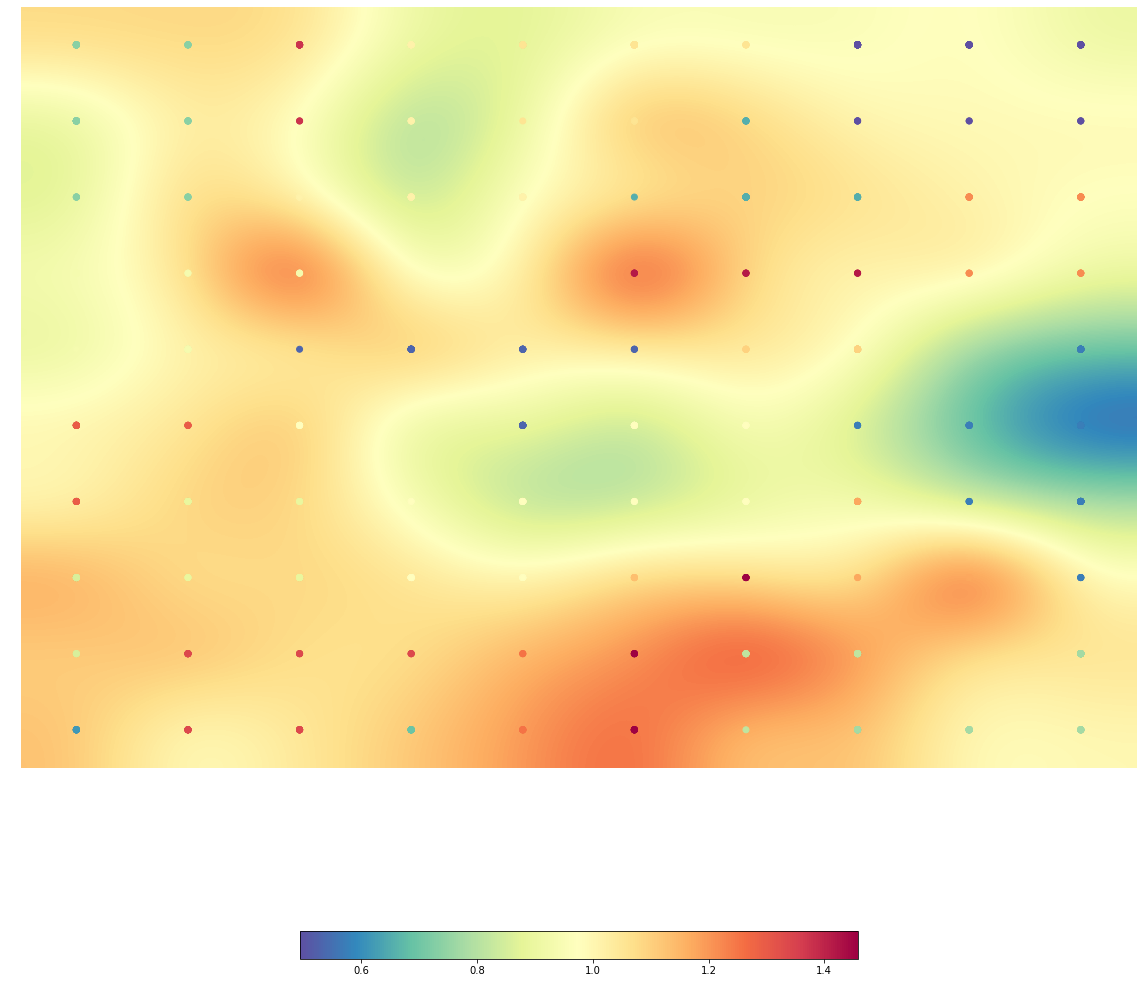

<module 'matplotlib.pyplot' from '/home/nbuser/anaconda3_501/lib/python3.6/site-packages/matplotlib/pyplot.py'>

In [9]:
n_clusters =25

algorithm = KMeans(n_clusters=n_clusters)
som.cluster(algorithm=algorithm)

som.view_umatrix(bestmatches=True,figsize=(20, 20),colorbar=True)

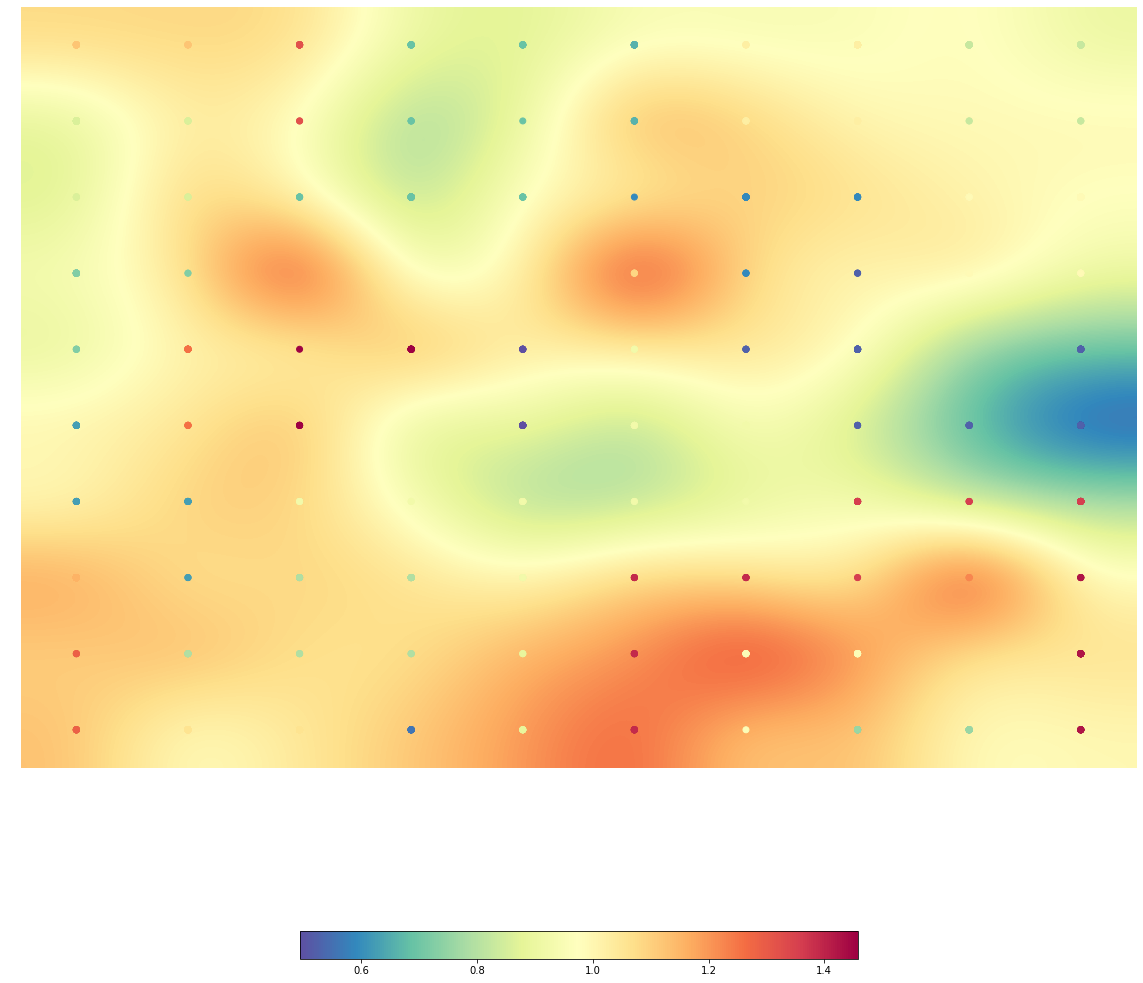

<module 'matplotlib.pyplot' from '/home/nbuser/anaconda3_501/lib/python3.6/site-packages/matplotlib/pyplot.py'>

In [10]:
n_clusters =30

algorithm = KMeans(n_clusters=n_clusters)
som.cluster(algorithm=algorithm)

som.view_umatrix(bestmatches=True,figsize=(20, 20),colorbar=True)

In [11]:
clusters = som.clusters 
clusters_sorted = np.unique(clusters, return_index = True, return_counts = True)
print ('Clusters sorted byincreasing number of neurons:\n',clusters_sorted[0])
print ('Cluster Starting Index:\n',clusters_sorted[1])
print ('Number Of Neurons Per Cluster:\n',clusters_sorted[2])

Clusters sorted byincreasing number of neurons:
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
Cluster Starting Index:
 [44 37 93 25 50  5  3 30 97 72  8 10 84 45 86 28  6 91 35  0 70 32 78 41
 80  2 67 75 79 42]
Number Of Neurons Per Cluster:
 [3 8 1 4 4 2 9 3 2 5 4 4 2 9 3 4 4 2 1 2 1 1 1 2 2 2 4 4 4 3]


In [12]:
print ('Clusters:\n',clusters)

Clusters:
 [[19 19 25  6  6  5 16 16 10 10]
 [11 11 25  6  6  5 16 16 10 10]
 [11 11  6  6  6  3  3  3 15 15]
 [ 7  7 21  6  6 18  3  1 15 15]
 [ 7 23 29 29  0 13  1  1  1  1]
 [ 4 23 29  0  0 13 13  1  1  1]
 [ 4  4 13 13 13 13 13 26 26 26]
 [20  4  9  9 13 27 27 26 22 28]
 [24  9  9  9 12 27 14 14 28 28]
 [24 17 17  2 12 27 14  8  8 28]]


## Αποθήκευση του SOM

Επειδή η αρχικοποίηση του SOM γίνεται τυχαία και το clustering είναι και αυτό στοχαστική διαδικασία, οι θέσεις και οι ετικέτες των νευρώνων και των clusters θα είναι διαφορετικές κάθε φορά που τρέχουμε τον χάρτη, ακόμα και με τις ίδιες παραμέτρους. Για να αποθηκεύσουμε ένα συγκεκριμένο som και clustering χρησιμοποιηούμε και πάλι την `joblib`. 


In [13]:
# Αποθήκευση του som
joblib.dump(som, 'som.pkl')

['som.pkl']

## Σημασιολογική ερμηνεία των clusters

Προκειμένου να μελετήσουμε τις τοπολογικές ιδιότητες του SOM και το αν έχουν ενσωματώσει σημασιολογική πληροφορία για τις ταινίες διαμέσου της διανυσματικής αναπαράστασης με το tf-idf και των κατηγοριών, χρειαζόμαστε ένα κριτήριο ποιοτικής επισκόπησης των clusters. Θα υλοποιήσουμε το εξής κριτήριο: Λαμβάνουμε όρισμα έναν αριθμό (ετικέτα) cluster. Για το cluster αυτό βρίσκουμε όλους τους νευρώνες που του έχουν ανατεθεί από τον k-Means. Για όλους τους νευρώνες αυτούς βρίσκουμε όλες τις ταινίες που τους έχουν ανατεθεί (για τις οποίες αποτελούν bmus). Για όλες αυτές τις ταινίες τυπώνουμε ταξινομημένη τη συνολική στατιστική όλων των ειδών (κατηγοριών) και τις συχνότητές τους. Αν το cluster διαθέτει καλή συνοχή και εξειδίκευση, θα πρέπει κάποιες κατηγορίες να έχουν σαφώς μεγαλύτερη συχνότητα από τις υπόλοιπες. Θα μπορούμε τότε να αναθέσουμε αυτήν/ές την/τις κατηγορία/ες ως ετικέτες κινηματογραφικού είδους στο cluster.

Μπορούμε να υλοποιήσουμε τη συνάρτηση αυτή όπως θέλουμε. Μια πιθανή διαδικασία θα μπορούσε να είναι η ακόλουθη:

1. Ορίζουμε συνάρτηση `print_categories_stats` που δέχεται ως είσοδο λίστα με ids ταινιών. Δημιουργούμε μια κενή λίστα συνολικών κατηγοριών. Στη συνέχεια, για κάθε ταινία επεξεργαζόμαστε το string `categories` ως εξής: δημιουργούμε μια λίστα διαχωρίζοντας το string κατάλληλα με την `split` και αφαιρούμε τα whitespaces μεταξύ ετικετών με την `strip`. Προσθέτουμε τη λίστα αυτή στη συνολική λίστα κατηγοριών με την `extend`. Τέλος χρησιμοποιούμε πάλι την `np.unique` για να μετρήσουμε συχνότητα μοναδικών ετικετών κατηγοριών και ταξινομούμε με την `np.argsort`. Τυπώνουμε τις κατηγορίες και τις συχνότητες εμφάνισης ταξινομημένα. Χρήσιμες μπορεί να σας φανούν και οι `np.ravel`, `np.nditer`, `np.array2string` και `zip`.

2. Ορίζουμε τη βασική μας συνάρτηση `print_cluster_neurons_movies_report` που δέχεται ως όρισμα τον αριθμό ενός cluster. Με τη χρήση της `np.where` μπορούμε να βρούμε τις συντεταγμένες των bmus που αντιστοιχούν στο cluster και με την `column_stack` να φτιάξουμε έναν πίνακα bmus για το cluster. Προσοχή στη σειρά (στήλη - σειρά) στον πίνακα bmus. Για κάθε bmu αυτού του πίνακα ελέγχουμε αν υπάρχει στον πίνακα μοναδικών bmus που έχουμε υπολογίσει στην αρχή συνολικά και αν ναι προσθέτουμε το αντίστοιχο index του νευρώνα σε μια λίστα. Χρήσιμες μπορεί να είναι και οι `np.rollaxis`, `np.append`, `np.asscalar`. Επίσης πιθανώς να πρέπει να υλοποιήσετε ένα κριτήριο ομοιότητας μεταξύ ενός bmu και ενός μοναδικού bmu από τον αρχικό πίνακα bmus.

3. Υλοποιούμε μια βοηθητική συνάρτηση `neuron_movies_report`. Λαμβάνει ένα σύνολο νευρώνων από την `print_cluster_neurons_movies_report` και μέσω της `indices` φτιάχνει μια λίστα με το σύνολο ταινιών που ανήκουν σε αυτούς τους νευρώνες. Στο τέλος καλεί με αυτή τη λίστα την `print_categories_stats` που τυπώνει τις στατιστικές των κατηγοριών.

1. Συνάρτηση print_categories_stats

In [14]:
def print_categories_stats(movies_to_check):
    total_cats = []

    for movie in movies_to_check:
        temp = categories[movie][0]
        temp = temp.split('"')
        temp = filter(lambda a: a != '', temp)
        temp = filter(lambda a: a != ',  ',temp)
        total_cats.extend(temp)

    total_cats_unique = np.unique(total_cats, return_counts = True)
    indices = np.argsort(total_cats_unique[1])
    indices = reversed(indices)
    tot = sum(total_cats_unique[1])

    print ('-'*25,'Statistics','-'*25)

    print ('{:<50} {:<20}'.format('Category', 'Percentage'))
    print ('-'*62)
    for i in indices:
        print ('{:<50} {:<20}'.format(total_cats_unique[0][i], str(round(total_cats_unique[1][i]*100.0/tot,3))+'%'))

2.Συνάρτηση `print_cluster_neurons_movies_report`

In [15]:
def print_cluster_neurons_movies_report(curr_cluster):
    print ('Cluster =',curr_cluster,'\n')
    new_indices = np.where(clusters == curr_cluster)
    new_indices = np.column_stack((new_indices[1],new_indices[0]))
    bmus_right = []
    for i in new_indices:
        if(i in bmus_unique[0]):
            bmus_right.append(i)
    bmus_right = np.array(bmus_right)
    return bmus_right

3.Συνάρτηση `neuron_movies_report`

In [16]:
def neuron_movies_report(curr_cluster):
    curr_bmus = print_cluster_neurons_movies_report(curr_cluster)
    movies_to_check = []

    for bmu in curr_bmus:
        for id in range(0,len(final_set),1):
            if(np.array_equal(bmu,bmus[id])):
                movies_to_check.append(id)
                
    print_categories_stats(movies_to_check)

In [17]:
clusters_to_check = range(0,n_clusters,1)

for curr_cluster in clusters_to_check:
    neuron_movies_report(curr_cluster)
    print ('-'*62,'\n\n')

Cluster = 0 

------------------------- Statistics -------------------------
Category                                           Percentage          
--------------------------------------------------------------
Documentary                                        35.556%             
Comedy film                                        17.778%             
History                                            6.667%              
Culture & Society                                  6.667%              
Biography                                          6.667%              
Social issues                                      4.444%              
Rockumentary                                       4.444%              
World cinema                                       2.222%              
Political cinema                                   2.222%              
Music                                              2.222%              
Media Studies                                      2.222%           

------------------------- Statistics -------------------------
Category                                           Percentage          
--------------------------------------------------------------
Comedy                                             20.915%             
Drama                                              20.261%             
Comedy-drama                                       7.843%              
Sports                                             5.229%              
Family Film                                        3.922%              
Black comedy                                       3.268%              
Indie                                              2.614%              
Film adaptation                                    1.961%              
Cult                                               1.961%              
Period piece                                       1.961%              
Parody                                             1.961%              
Ensemble F

------------------------- Statistics -------------------------
Category                                           Percentage          
--------------------------------------------------------------
Comedy                                             43.548%             
Black-and-white                                    5.376%              
Family Film                                        5.376%              
Romance Film                                       4.839%              
Musical                                            3.763%              
Slapstick                                          3.763%              
Indie                                              3.763%              
World cinema                                       2.151%              
Action                                             1.613%              
Sports                                             1.613%              
Crime Fiction                                      1.613%              
Children's

------------------------- Statistics -------------------------
Category                                           Percentage          
--------------------------------------------------------------
Horror                                             36.893%             
Science Fiction                                    7.767%              
Zombie Film                                        4.854%              
Comedy                                             4.854%              
World cinema                                       3.883%              
Supernatural                                       3.883%              
Drama                                              2.913%              
Japanese Movies                                    2.913%              
Creature Film                                      2.913%              
Mystery                                            2.913%              
Psychological thriller                             2.913%              
Short Film

------------------------- Statistics -------------------------
Category                                           Percentage          
--------------------------------------------------------------
Romance Film                                       25.287%             
Drama                                              25.287%             
Comedy                                             9.195%              
Romantic comedy                                    4.598%              
Indie                                              4.023%              
Comedy-drama                                       2.874%              
Coming of age                                      2.874%              
Black-and-white                                    1.724%              
Comedy film                                        1.724%              
Romantic drama                                     1.724%              
War film                                           1.149%              
Film adapt

------------------------- Statistics -------------------------
Category                                           Percentage          
--------------------------------------------------------------
Thriller                                           14.423%             
Crime Fiction                                      14.423%             
Crime Thriller                                     14.423%             
Drama                                              10.577%             
Mystery                                            6.731%              
Black-and-white                                    4.808%              
Suspense                                           4.808%              
Detective                                          3.846%              
Detective fiction                                  3.846%              
Indie                                              2.885%              
Psychological thriller                             2.885%              
World cine

------------------------- Statistics -------------------------
Category                                           Percentage          
--------------------------------------------------------------
Comedy                                             22.667%             
Parody                                             20.0%               
Satire                                             8.0%                
Cult                                               5.333%              
Slapstick                                          4.0%                
Science Fiction                                    4.0%                
Gross out                                          2.667%              
Black comedy                                       2.667%              
Comedy-drama                                       2.667%              
Crime Fiction                                      2.667%              
Absurdism                                          2.667%              
Gross-out 

## Ανάλυση τοπολογικών ιδιοτήτων χάρτη SOM


Άλλη μία παρατήρηση είναι ότι δεδομένα που έχουν μεγαλύτερη πυκνότητα πιθανότητας στο χώρο εισόδου τείνουν να απεικονίζονται με περισσότερους νευρώνες στο χώρο μειωμένης διαστατικότητας. 

Παρατηρούμε ότι μακρινά πρότυπα εισόδου τείνουν να απεικονίζονται απομακρυσμένα στο χάρτη.

